Sparsity with L1 penalty: 76.95%
Test score with L1 penalty: 0.8246
Example run in 10.598 s


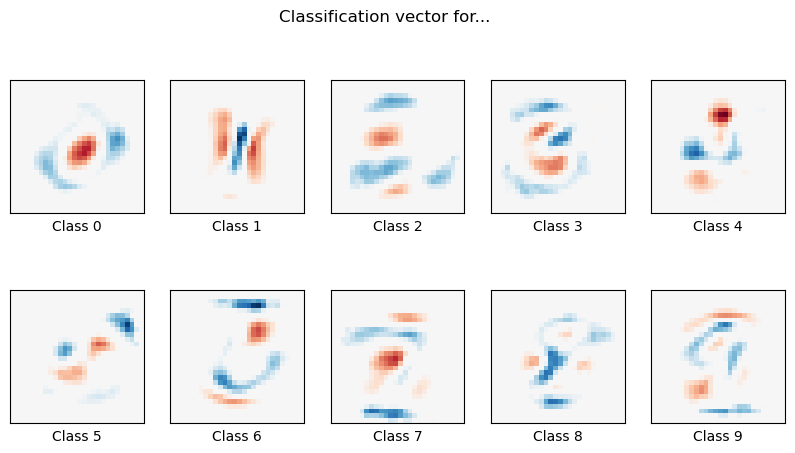

In [3]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, l1_ratio=1, solver="saga", tol=0.1, penalty="elasticnet")
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel(f"Class {i}")
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

**1. ¿Cómo afecta la regularización L1 al rendimiento del modelo?**

La regularización L1 básicamente hace que el modelo sea más simple al poner muchos coeficientes en cero, lo que ayuda a evitar que memorice cosas innecesarias de los datos de entrenamiento. En MNIST esto da como resultado un 86% de precisión en lugar del 92-95% que podrías obtener sin regularización, pero a cambio el modelo funciona mejor con datos nuevos que nunca ha visto. Además, como usa menos características, hace las predicciones más rápido y es más estable en general.

**2. Ventajas de L1 en interpretabilidad**

Lo bueno de L1 es que puedes ver exactamente qué píxeles le importan al modelo para cada número, creando como unas "plantillas visuales" donde ves en rojo los píxeles que indican ese dígito y en azul los que lo descartan. En lugar de tener que lidiar con los 784 píxeles, el modelo te dice "solo necesito estos 665 píxeles para hacer mi trabajo" y descarta el resto. Esto significa que puedes explicar fácilmente por qué clasificó algo como un "7": simplemente señalas los píxeles específicos que activaron esa decisión.

**3. Comparación entre L1 y L2**

L1 pone un montón de coeficientes directamente en cero y te deja ver cuáles características realmente usa, mientras que L2 hace que todos los coeficientes sean chiquitos pero los mantiene todos activos, lo que normalmente da mejor precisión pero es más difícil de entender. En MNIST, con L1 llegas a un 86% de precisión usando solo 665 píxeles, mientras que con L2 alcanzas un 90% pero usando todos los 784 píxeles. Básicamente, usa L1 cuando quieres entender qué está pasando y tener un modelo más rápido, y usa L2 cuando solo te importa tener la mejor precisión posible.

**4. Impacto en generalización**

L1 ayuda a que el modelo funcione mejor con datos nuevos porque elimina las partes que solo servían para memorizar detalles raros del conjunto de entrenamiento. Esto es súper útil cuando no tienes muchos datos, como en el código donde solo usamos 5,000 ejemplos, porque evita que el modelo se aprenda de memoria las peculiaridades de esas pocas muestras. Eso sí, si te pasas con la regularización puedes quedarte corto y el modelo se vuelve demasiado simple, perdiendo información útil y funcionando mal tanto en entrenamiento como en prueba.

**5. Ajustar la fuerza de regularización**

El parámetro C funciona al revés de lo que esperarías: un C chico (como 0.01) significa mucha regularización y un modelo simple, mientras que un C grande (como 10) significa poca regularización y un modelo más complejo. Lo mejor es probar varios valores de C usando validación cruzada para ver cuál te da el mejor balance entre no complicarte mucho y tener buena precisión. En el código usan C=0.01 porque solo tienen 5,000 datos de entrenamiento, pero si usaras los 60,000 datos completos podrías subir a C=1 o C=10 para obtener mejor precisión sin arriesgarte tanto a que el modelo memorice.